```python
- 파스칼VOC 클래스 20종 (배경 포함 21종)
{'__background__': 0, 

'aeroplane': 1, 

'bicycle': 2, 

'bird': 3,

'boat': 4, 

'bottle': 5,

'bus': 6, 

'car': 7,

'cat': 8,

'chair': 9,

'cow': 10, 

'diningtable': 11, 

'dog': 12, 

'horse': 13, 

'motorbike': 14, 

'person': 15,

'pottedplant': 16,

'sheep': 17,

'sofa': 18,

'train': 19,

'tvmonitor': 20}

```

In [1]:
import os
import matplotlib.pyplot as plt
from pixellib.semantic import semantic_segmentation
import cv2
import numpy as np


In [2]:
# PASCAL VOC 데이터 Class 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [7]:
def shallow_focus(img_path, class_name, model_path, bg_img=None):

    _img = cv2.imread(img_path)
    _class_id = LABEL_NAMES.index(class_name)

    model = semantic_segmentation()
    model.load_pascalvoc_model(model_path)
    
    # 
    output, segmap = model.segmentAsPascalvoc(img_path)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
    plt.title("A raw image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(segmap, cv2.COLOR_BGR2RGB))
    plt.title("A semantic segmentation image")

        
    _class_name = []
    for class_id in output['class_ids']:
        _class_name.append(LABEL_NAMES[class_id])
    print(f"위 사진에서 다음 클래스를 찾았습니다. {_class_name}")
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    #colormap[Integer]의 결과는 BGR순이므로 RGB순으로 바꾸어야 함
    colormap_rgb = tuple(colormap[_class_id][::-1])
    seg_map = np.all(segmap==colormap_rgb, axis=-1) 

    plt.subplot(2, 2, 3)
    plt.imshow(seg_map, cmap='gray')

    
    # 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
    img_show = _img.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
    img_orig_blur = cv2.blur(_img, (50,50))
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    if bg_img is None:
        img_concat = np.where(img_mask_color==255, _img, img_bg_blur)
    else:
        #원본 size(w, h)를 합성배경의 size와 맞춰야 한다.
        _h, _w, _ = img_bg_blur.shape
        _bg = cv2.imread(bg_img)
        _bg = cv2.resize(_bg, (_w, _h))
        img_concat = np.where(img_mask_color==255, _img, _bg)
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
      
    return 0

#### 아웃포커싱 효과를 사람에 적용해보기

위 사진에서 다음 클래스를 찾았습니다. ['background', 'chair', 'person', 'sofa']


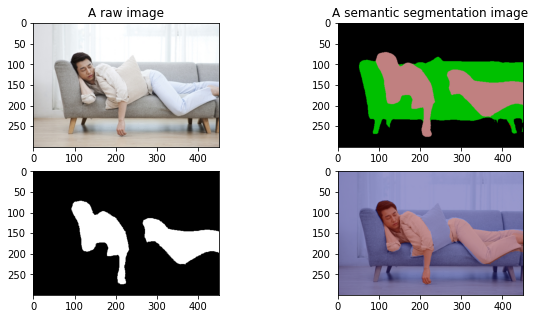

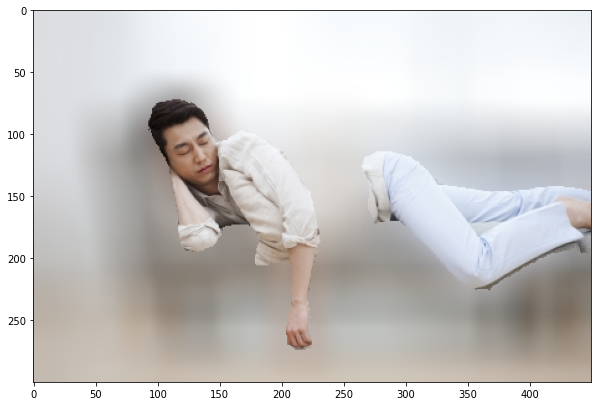

0

In [4]:
img_path = 'images/sleeping_person.jpg'
model_path = 'models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

shallow_focus(img_path, 'person', model_path)

#### 아웃포커싱 효과를 동물에 적용해보기

위 사진에서 다음 클래스를 찾았습니다. ['background', 'cow']


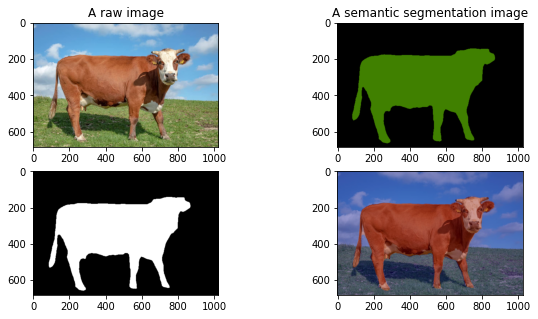

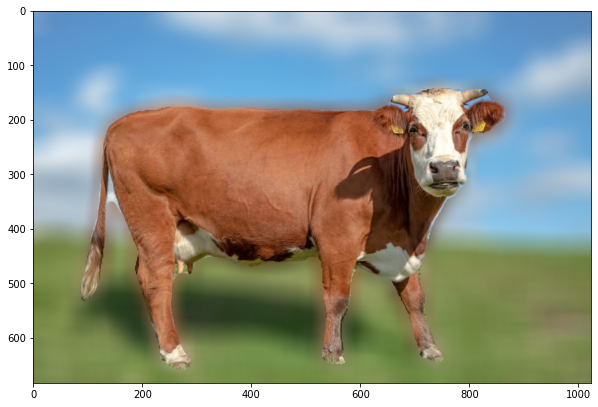

0

In [5]:
img_path = 'images/Fleckvieh_Cattle_1024x683.jpg'
model_path = 'models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

shallow_focus(img_path, 'cow', model_path)

### 배경 크로마키로 합성해보기

푸른 초원이 아닌 도로 한복판에 소를 데려오겠다.


위 사진에서 다음 클래스를 찾았습니다. ['background', 'cow']


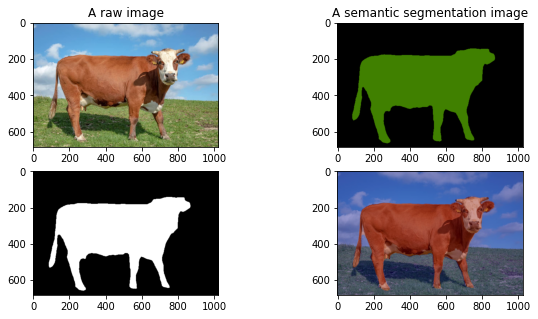

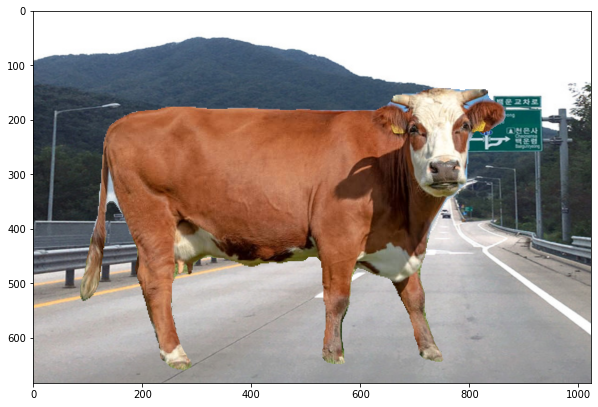

0

In [8]:
img_path = 'images/Fleckvieh_Cattle_1024x683.jpg'
model_path = 'models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
bg_img = 'images/road.jpg'

shallow_focus(img_path, 'cow', model_path, bg_img)

## 인물사진에서 발생한 문제점을 정확히 지적한 사진
![](https://velog.velcdn.com/images/joonlaxy/post/5dc4febd-d475-4999-9384-24de11d6fd3c/image.png)

## semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션

### 좋은 솔루션

#### 데이터 센트릭 관점
실제 산업에서는 요즘 모델센트릭 -> 데이터센트릭으로 추세가 변하고 있다.
이를 쉽게 얘기하면 학습 데이터 구축 과정에서 데이터라벨링(세그멘테이션작업)을 더욱 픽셀단위로 더욱 꼼꼼하게 데이터를 구축하는 것이 있다.

![](https://velog.velcdn.com/images%2Fkimkj38%2Fpost%2F5bc14277-e055-4d19-8085-36ee4eeece94%2Fimage.png)

어떻게 픽셀단위로 세그멘테이션을 라벨링 작업을하고 이를 통해 모델을 학습하는것이 segmentation mask 오류를 극복할 수 있는 가장 좋은 방법이라고 생각한다. 

#### 모델 센트릭 관점

##### 모델의 성능 지표
모델을 선택할때 모델의 성능 지표를 확인하는 방법이 있다. 

앞서 Dice는 특이하게 loss function으로도 쓰이지만, metric으로도 사용된다.
(그 이유는 segmentation이라는 task의 특수성 때문인데, pixel별로 class를 예측하기 때문에 metric score의 변화가 상당히 연속적이라 대부분의 구간에서 미분값이 유의미하기 때문이다.)
(classification task에서 accuracy를 가지고 loss function으로 사용하지 않는 이유와 반대로 비슷하게 생각하면 된다.)


```python
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice1
```

##### SOTA 모델 선정
사용할 데이터셋에 가장 SOTA(State-Of-The-Art, 현 최고 성능 알고리즘)가 높은 모델을 선정하는 방법이 있다.
Semantic Segmentation에서는 https://paperswithcode.com/task/semantic-segmentation 사이트에서 확인할 수 있다.
우리가 이번에 사용한 PascalVOC 데이터셋에서는 지금 사용한 모델이 SOTA 모델이라 더 좋은 모델을 선정하기 어려워 보인다.
